# Using QSVT for Fixed-point Amplitude Amplification

This demo shows how to use the QSVT framework for search problems; specifically, implementing fixed-point amplitude amplification (FPAA). With FPAA, we do not know in advance the concentration of solutions for the search problem, but we want to sample a solution with high probability. In contrast, for the original Grover search algorithm, too many iterations might 'overshoot' the mark.

The demo is based on the paper [Grand unification of quantum algorithms](#grand).

Given $|s\rangle$ the initial state and $|t\rangle$ the 'good' states, we get an effective block encoding of a one-dimensional matrix $A=|t\rangle\langle s|$.

Given that  $a = \langle s|t\rangle\gt0$, we want to amplify $a$. The signal operator $U$ here is $I$ (and also $U^\dagger$). Now we implement two projector-rotations: one in the '$|s\rangle$' space and one in the '$|t\rangle$' space; each one around the given state, giving phase to the specific state.

In [ ]:
!pip install -qq "classiq[qsp]" -U

## Defining the QSVT Circuit for the Problem

In [2]:
import numpy as np

from classiq import *

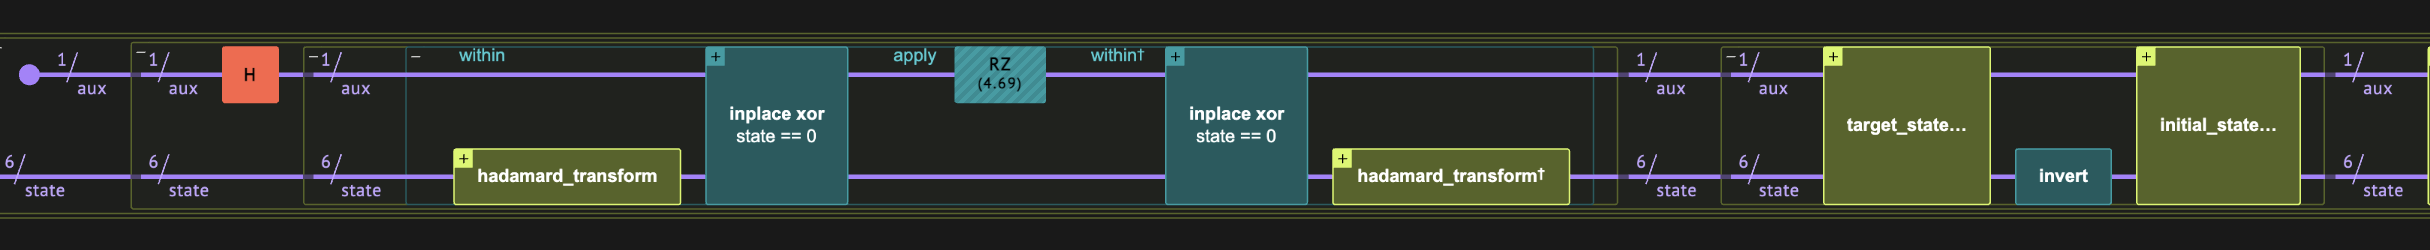

We start with the general QSVT framework definition. It accepts a unitary that block-encodes a matrix together with projector-controlled phase functions, which rotate the state around each of the subspaces where the matrix is encoded.

The `qsvt` function accepts 3 different functions:
1. **Block Encoding function**: the one for which the singular values are transformed. In this case, the block encoding is trivial, and is just the Identity.
2. **Domain projector-controlled-CNot**: a function that identifies subspace in the domain of the block encoding (i.e the columns of the block encoding). In our case it is an identifier for the initial state $|s\rangle$.
3. **Image projector-controlled-CNot**: a function that identifies subspace in the image of the block encoding (i.e the rows of the block encoding). In our case it is an identifier for the target state $|t\rangle$.

So we get a 1x1 block encoded matrix, which will be transformed using a polynomial that approximates the sign function, so that all inputs will be amplified to approximately 1. We need an even degree polynomial since we need to "finish" our sequence in the image space of our unitary.

## Domain State Projector: identify the $|s\rangle$ state

In [3]:
@qfunc
def initial_state_projector(state: QNum, aux: QBit):
    within_apply(
        lambda: hadamard_transform(state), lambda: inplace_xor(state == 0, aux)
    )

## Image States Projector: identify the $|t\rangle$ state

In [4]:
@qfunc
def target_state_projector(
    arith_oracle: QCallable[QArray, QBit],
    state: QArray,
    aux: QBit,
):
    arith_oracle(state, aux)

## Defining the Arithmetic Oracle

We implement the following equation: 
`(a + b) == 3 and (c - a) == 2`
with `a, b, c` in sizes 2, 1, 3:

In [15]:
from classiq.qmod.symbolic import logical_and


class OracleVars(QStruct):
    a: QNum[2]
    b: QNum[1]
    c: QNum[3]


@qfunc
def arith_equation(state: OracleVars, res: QBit):
    res ^= logical_and((state.a + state.b) == 3, (state.c - state.a) == 2)

## Wrapping Everything for the FPAA Case

In the FPAA case, the provided unitary is just the Identity matrix! In addition, we provide defined projector functions:

In [28]:
@qfunc
def qsvt_fpaa(
    phase_seq: CArray[CReal],
    arith_oracle: QCallable[Const[OracleVars], QBit],
    state: OracleVars,
    aux: Output[QBit],
):
    allocate(aux)

    qsvt(
        phase_seq,
        proj_cnot_1=lambda _aux: initial_state_projector(state, _aux),
        proj_cnot_2=lambda _aux: target_state_projector(arith_equation, state, _aux),
        u=lambda: None,
        aux=aux,
    )

## Getting the Phase Sequence for the Sign Function

Here for demonstration purpose we assume that the initial state has at least `MIN_OVERLAP=0.1` with the target state (in probability). So we approximate the constant function (a scale of 0.95 is used for stability), and we only care about the interval [`MIN_OVERLAP`, 1].

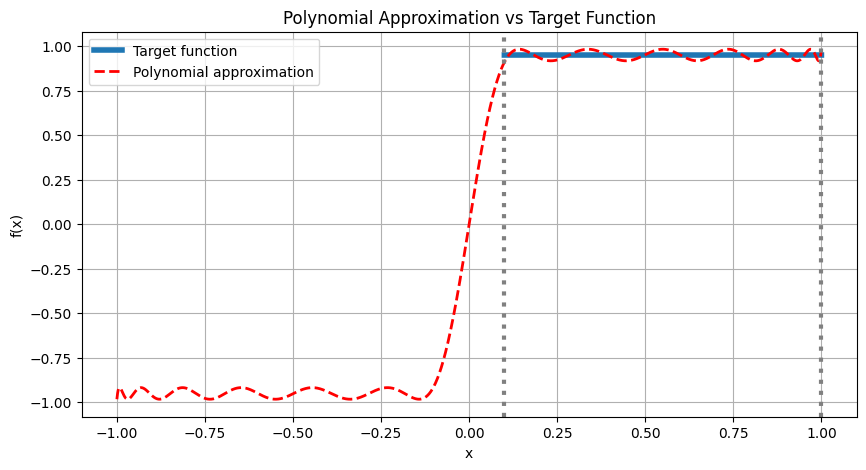

0.03252868313167301


In [29]:
from classiq.applications.qsp import qsp_approximate, qsvt_phases

DEGREE = 25
SCALE = 0.95
MIN_OVERLAP = 0.1


def target_function(x):
    return SCALE * np.sign(x)


pcoefs, max_err = qsp_approximate(
    target_function, degree=DEGREE, parity=1, interval=[MIN_OVERLAP, 1], plot=True
)
print(max_err)
phases = qsvt_phases(pcoefs)

## Creating the Full QSVT Model

In [30]:
@qfunc
def main(state: Output[OracleVars], aux: Output[QBit]):
    allocate(state)
    hadamard_transform(state)

    qsvt_fpaa(
        phase_seq=phases,
        arith_oracle=arith_equation,
        state=state,
        aux=aux,
    )

## Synthesizing and Executing on a Simulator

We use the Classiq synthesis engine to translate the model to a quantum circuit, and execute on the Classiq simulator:

In [31]:
write_qmod(main, "qsvt_fixed_point_amplitude_amplification")
qprog = synthesize(
    main,
    constraints=Constraints(max_width=12),
)

show(qprog)

Quantum program link: https://platform.classiq.io/circuit/34kFUoNFg6jZWrAlUvlvL1YFPNO


Execute the circuit:

In [32]:
result = execute(qprog).result_value()

In [33]:
def equation(a, b, c):
    return ((a + b) == 3) and ((c - a) == 2)


measured_good_shots = 0

for r in result.parsed_counts:
    a, b, c, aux = (
        r.state["state"]["a"],
        r.state["state"]["b"],
        r.state["state"]["c"],
        r.state["aux"],
    )
    if equation(a, b, c) and (aux == 0):
        print(
            f"a: {a}, b: {b}, c: {c}, aux: {aux}, equation_result: {equation(a, b, c)}, counts={r.shots}"
        )
        measured_good_shots += r.shots

print("Measured good shots:", measured_good_shots)

a: 2, b: 1, c: 4, aux: 0, equation_result: True, counts=957
a: 3, b: 0, c: 5, aux: 0, equation_result: True, counts=934
Measured good shots: 1891


What do we expect?

We need to substitute the amplitude of $|s\rangle\langle t|$ in $P(x)$:

In [36]:
poly_cheb = np.polynomial.Chebyshev(pcoefs)
p_good_shot = poly_cheb(np.sqrt(2 / 2**6)) ** 2
print("Expected good shots:", result.num_shots * p_good_shot)

Expected good shots: 1878.189404991538


Indeed, we received the expected result according to the polynomial we created with the QSVT sequence:

In [38]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/34kFaP8QVChvvePVONBzLvbTc1s


In [35]:
import scipy

assert np.isclose(
    measured_good_shots,
    result.num_shots * p_good_shot,
    atol=5 * scipy.stats.binom.std(result.num_shots, p_good_shot),
)

## References

<a id='grand'>[1]</a>: [Martyn JM, Rossi ZM, Tan AK, Chuang IL. Grand unification of quantum algorithms. PRX Quantum. 2021 Dec 3;2(4):040203.](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.040203)
